# Samuel Watkins, 3032132676
# HW 4: Parallelism
Python Computer for Data Science, UC Berkeley 2018  
Due Monday 2PM, March 5, 2018

Write a program that runs this algorithm under the three different 
parallelization methods. Run several trials with different numbers of darts 
thrown (up to execution times ~100 seconds). Keep track of the 
execution times as a function of number of darts and method of 
parallelization. Also, keep track of the simulation rate (darts thrown per 
second).

First, we import all needed packages and define the Monte Carlo function that we will use

In [31]:
from math import sqrt
from random import uniform
from time import time,sleep
from multiprocessing import Pool
import ipyparallel as ipp
import numpy as np

# function for doing a single monte carlo for a specified number of darts
def MCpi(number_of_darts):
    number_of_darts_in_circle = 0.0 # initialize num of darts as zero
    
    # loop over all darts
    for n in range(number_of_darts):
        # throw a dart randomly in a 1x1 square
        x,y = uniform(0,1),uniform(0,1)
        # if the dart landed in a circle of radius 0.5, then count it as a dart in the circle
        if sqrt((x-0.5)**2+(y-0.5)**2)<=0.5:
            number_of_darts_in_circle += 1.0
    # give number of darts in the circle
    return number_of_darts_in_circle

# function for throwing a single dart (for use with ipyparallel)
def throwdart(x):
    # need to import the functions
    from random import uniform
    from math import sqrt
    
    # throw a dart randomly in a 1x1 square
    x,y = uniform(0,1),uniform(0,1)
    
    # if a dart is in a circle of radius 0.5, then return True, otherwise return False
    if sqrt((x-0.5)**2+(y-0.5)**2)<=0.5:
        dart_in_circle = True
    else:
        dart_in_circle = False
    
    return dart_in_circle


Next, we initialize the variables that will store the darts thrown, the execution times, and the simulation rates

In [32]:
# create an array of the darts that we want to throw, ranging from 10 to 10,000,000
darts_range = np.logspace(1,7,num=10,dtype=int)

# number of simulations to run for calculating mean and standard deviation for each method at each point
nSims = 10

# initialize arrays for storing the execution times and simulation rates and their standard deviations
# simple serial case
mean_serial_times = np.zeros(len(darts_range))
mean_serial_rates = np.zeros(len(darts_range))
std_serial_times = np.zeros(len(darts_range))
std_serial_rates = np.zeros(len(darts_range))

# multiprocessing case
mean_mp_times = np.zeros(len(darts_range))
mean_mp_rates = np.zeros(len(darts_range))
std_mp_times = np.zeros(len(darts_range))
std_mp_rates = np.zeros(len(darts_range))

# ipyparallel case
mean_ipp_times = np.zeros(len(darts_range))
mean_ipp_rates = np.zeros(len(darts_range))
std_ipp_times = np.zeros(len(darts_range))
std_ipp_rates = np.zeros(len(darts_range))

Let's start with doing the simple serial simulation of calculating pi, keeping the execution times and simulation rates for each number of darts thrown.

In [33]:
# simple serial 

    
# loop over each of the number of darts thrown in darts_range, doing the Monte Carlo in simple series
for iTrial in range(len(darts_range)):
    
    # initialize empty lists for this number of darts
    serial_times = []
    serial_rates = []
    
    # do the simulation multiple times to get a mean and standard deviation of the results
    for iSim in range(nSims):

        number_of_darts = darts_range[iTrial] # set the number of darts thrown

        start_time = time() # start time of the calculation
        number_of_darts_in_circle = MCpi(number_of_darts) # run the monte carlo simulation
        end_time = time() # end time of the calculation

        # temporarily save the values to our arrays
        serial_times.append(end_time - start_time)
        serial_rates.append(number_of_darts/serial_times[-1])
    
    # calculate the mean and standard deviation
    mean_serial_times[iTrial] = np.mean(serial_times)
    mean_serial_rates[iTrial] = np.mean(serial_rates)
    std_serial_times[iTrial] = np.std(serial_times)
    std_serial_rates[iTrial] = np.std(serial_rates)


Next, let's do the multiprocessing simulation of calculating pi, keeping the execution times and simulation rates for each number of darts thrown. We will use 16 processes, as it seemed like a good balance of speed through trial and error of playing with different values.

In [34]:
# multiprocessing

# open up 16 processes to run the monte carlo in parallel
num_processes = 16
pool = Pool(processes=num_processes)

# loop over each of the number of darts thrown in darts_range, doing the Monte Carlo using multiprocessing
for iTrial in range(len(darts_range)):
    
    number_of_darts = darts_range[iTrial] # set the number of darts thrown
    
    # have each process do a separate monte carlo of the total number of darts/number of processes
    darts_per_process = [int(number_of_darts/num_processes) for x in range(num_processes)]
    
    # since the above code can undercount the number of darts desired, we add a single dart to each process until
    # we have the right amount of darts
    ii=0
    while sum(darts_per_process)<number_of_darts:
        if ii>=num_processes:
            ii=0
        darts_per_process[ii]+=1
        ii+=1
    
    # initialize empty lists for this number of darts
    mp_times = []
    mp_rates = []
    
    # do the simulation multiple times to get a mean and standard deviation of the results
    for iSim in range(nSims):
        
        start_time = time()# start time of the calculation
        ndarts_per_pool = pool.map(MCpi,darts_per_process) # start each process
        number_of_darts_in_circle = sum(ndarts_per_pool) # sum up the number of darts in the circle found by each process
        end_time = time() # end time of the calculation
        
        # temporarily save the values to our arrays
        mp_times.append(end_time - start_time)
        mp_rates.append(number_of_darts/mp_times[-1])

    # calculate the mean and standard deviation
    mean_mp_times[iTrial] = np.mean(mp_times)
    mean_mp_rates[iTrial] = np.mean(mp_rates)
    std_mp_times[iTrial] = np.std(mp_times)
    std_mp_rates[iTrial] = np.std(mp_rates)


pool.terminate()
del pool

Lastly, let's do the iPyParallel simulation of calculating pi, keeping the execution times and simulation rates for each number of darts thrown.

**NOTE**: this code assumes the user has already run  
```
ipcluster start -n 4
```
in the command line. If this has not been done, then the user will run into an error that there are no ipcluster engines available.

In [35]:
# ipyparallel

# open up the ipyparallel client
rc = ipp.Client()
# open a view
v = rc[:]

# loop over each of the number of darts thrown in darts_range, doing the Monte Carlo using ipyparallel
for iTrial in range(len(darts_range)):
    
    number_of_darts = darts_range[iTrial] # set the number of darts thrown

    # initialize empty lists for this number of darts
    ipp_times = []
    ipp_rates = []
    
    for iSim in range(nSims):
        
        start_time = time()# start time of the calculation\
        out = v.map_sync(throwdart,range(number_of_darts)) # have ipyparallel throw the darts in parallel
        number_of_darts_in_circle = sum(out) # sum up the number of darts in the circle found by each process
        end_time = time() # end time of the calculation

        # temporarily save the values to our arrays
        ipp_times.append(end_time - start_time)
        ipp_rates.append(number_of_darts/ipp_times[-1])
    
    # calculate the mean and standard deviation
    mean_ipp_times[iTrial] = np.mean(ipp_times)
    mean_ipp_rates[iTrial] = np.mean(ipp_rates)
    std_ipp_times[iTrial] = np.std(ipp_times)
    std_ipp_rates[iTrial] = np.std(ipp_rates)
    
    

/home/sam/anaconda3/lib/python3.6/site-packages/ipyparallel/client/client.py:458: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@sam-ubuntu')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


With the simulations run, we can now plot the results!

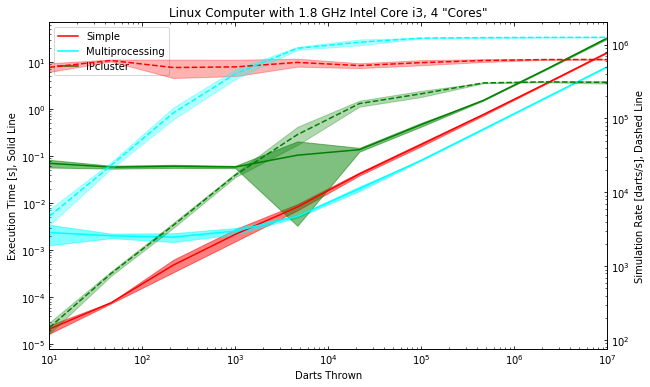

In [37]:
%matplotlib inline

import matplotlib.pyplot as plt

# make the plot showing execution times and simulation rate for each method as a function of darts thrown
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title("Linux Computer with 1.8 GHz Intel Core i3, 4 \"Cores\"")

# plot the execution times with the error bars
ax1.plot(darts_range,mean_serial_times,label="Simple",color="red")
ax1.fill_between(darts_range,mean_serial_times-std_serial_times,mean_serial_times+std_serial_times,color="red",alpha=0.5)

ax1.plot(darts_range,mean_mp_times,label="Multiprocessing",color="cyan")
ax1.fill_between(darts_range,mean_mp_times-std_mp_times,mean_mp_times+std_mp_times,color="cyan",alpha=0.5)

ax1.plot(darts_range,mean_ipp_times,label="IPcluster",color="green")
ax1.fill_between(darts_range,mean_ipp_times-std_ipp_times,mean_ipp_times+std_ipp_times,color="green",alpha=0.5)

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlim([darts_range[0],darts_range[-1]])
ax1.tick_params(which="both",top="on",direction="in")
ax1.legend()
ax1.set_xlabel("Darts Thrown");
ax1.set_ylabel("Execution Time [s], Solid Line");


ax2 = ax1.twinx()

# plot the simulation rates with the error bars
ax2.plot(darts_range,mean_serial_rates,label="Simple",color="red",linestyle="dashed")
ax2.fill_between(darts_range,mean_serial_rates-std_serial_rates,mean_serial_rates+std_serial_rates,color="red",alpha=0.3)

ax2.plot(darts_range,mean_mp_rates,label="Multiprocessing",color="cyan",linestyle="dashed")
ax2.fill_between(darts_range,mean_mp_rates-std_mp_rates,mean_mp_rates+std_mp_rates,color="cyan",alpha=0.3)

ax2.plot(darts_range,mean_ipp_rates,label="IPcluster",color="green",linestyle="dashed")
ax2.fill_between(darts_range,mean_ipp_rates-std_ipp_rates,mean_ipp_rates+std_ipp_rates,color="green",alpha=0.3)

ax2.set_ylabel("Simulation Rate [darts/s], Dashed Line");
ax2.set_yscale('log')
ax2.tick_params(which="both",direction="in")

# save the figure to this folder (uncomment to overwrite the already saved figure)
fig.savefig("simulation.png")